In [85]:
import numpy as np
import statsmodels
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from IPython.display import Image
Image(url='http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png')

# Regression, Covariance matrices, and autocorrelation

The easiest way to perform a least-squares fit (linear or non-linear) is to use the scipt.optimize curve_fit function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). Simply define the model you want to use for least-squares and feed it to curve_fit: 

In [86]:
def func(x, a, b, c):
    #-- Here we are interested in a quadratic fit
    return a*x**2+b*x+c

In [87]:
x_points = np.arange(50)
#-- use coefficients 2,3,1 and with random noise
y_points = func(x_points,0.5,1,2)+np.random.normal(size=x_points.size)
popt, pcov = curve_fit(func, x_points, y_points)
print 'Cofficients:\n', popt
print 'covariance matrix:\n', pcov

Cofficients:
[ 0.50120503  0.96166586  1.96260756]
covariance matrix:
[[  6.67080879e-07  -3.26869634e-05   2.61495857e-04]
 [ -3.26869634e-05   1.71266304e-03  -1.55328416e-02]
 [  2.61495857e-04  -1.55328416e-02   1.92251449e-01]]


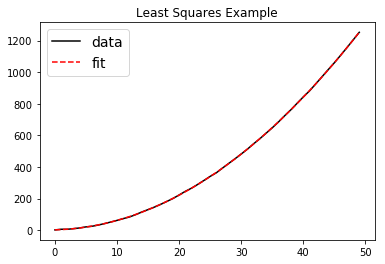

In [88]:
#-- plot the results
plt.plot(x_points,y_points,'k-',label='data')
plt.plot(x_points,func(x_points,*popt),'r--',label='fit')
plt.legend(fontsize=14)
plt.title("Least Squares Example")
plt.show()

For Oridnary Linear Squares, one can also use the OLS module in statsmodels (http://statsmodels.sourceforge.net/0.6.0/examples/notebooks/generated/ols.html).  Using this same example as above, first we create our $x$ matrix and our parameter vector $\beta$:

$ x= 
\begin{bmatrix}
    1 & x_1 & x_1^2 \\
    \vdots & \vdots & \vdots \\
    1 & x_n & x_n^2 
\end{bmatrix} $

$ \beta =  
\begin{bmatrix}
    1\\
    2.3\\
    1.2
\end{bmatrix} $

In [89]:
X = np.column_stack((x_points, x_points**2))
#-- add constant term
X = sm.add_constant(X)
#-- beta vector
beta = np.array([2, 1, 0.5])
y = np.dot(X, beta)+np.random.normal(size=x_points.size)

#-- Now define model
model = sm.OLS(y, X)
#-- fit and display results
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.916e+06
Date:                Mon, 20 Mar 2017   Prob (F-statistic):          1.98e-120
Time:                        01:08:12   Log-Likelihood:                -74.689
No. Observations:                  50   AIC:                             155.4
Df Residuals:                      47   BIC:                             161.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5518      0.453      5.629      0.0

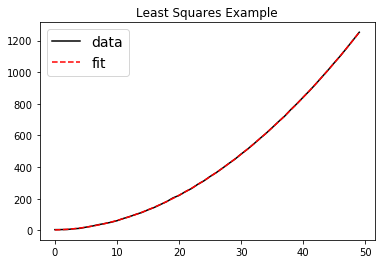

In [90]:
#-- plot the results
plt.plot(x_points,y,'k-',label='data')
plt.plot(x_points,np.dot(X,results.params),'r--',label='fit')
plt.legend(fontsize=14)
plt.title("Least Squares Example")
plt.show()

While the covariance matrix gives us the covariance of each parameter with another parameter following regression, one can also look at patterns in a stochastic process. One can shift time-series or spatial data and look at the correlation of data with the shifted version of itself to look for correlations within the stochastic process. This is known as autocorrelation. 

***  explanation of dicrete autocorrelation at two points and the autocorrelation matrix to be filled in later ***

In order to implement this, we can again use the statsmodels package. We will use datasets from the statsmodels Datasets packages that are also available in R.

In [91]:
data = sm.datasets.longley.load()
#-- data.exog is a matrix of k obervation variables (columns) by n obervation instances (rows).
#-- This is exactly analogous to how X was defined in the example above.
#-- Also add an intercept (n ones)
data.exog = sm.add_constant(data.exog)
#-- get overview of data
data.data

rec.array([( 60323.,   83. ,  234289.,  2356.,  1590.,  107608.,  1947.),
 ( 61122.,   88.5,  259426.,  2325.,  1456.,  108632.,  1948.),
 ( 60171.,   88.2,  258054.,  3682.,  1616.,  109773.,  1949.),
 ( 61187.,   89.5,  284599.,  3351.,  1650.,  110929.,  1950.),
 ( 63221.,   96.2,  328975.,  2099.,  3099.,  112075.,  1951.),
 ( 63639.,   98.1,  346999.,  1932.,  3594.,  113270.,  1952.),
 ( 64989.,   99. ,  365385.,  1870.,  3547.,  115094.,  1953.),
 ( 63761.,  100. ,  363112.,  3578.,  3350.,  116219.,  1954.),
 ( 66019.,  101.2,  397469.,  2904.,  3048.,  117388.,  1955.),
 ( 67857.,  104.6,  419180.,  2822.,  2857.,  118734.,  1956.),
 ( 68169.,  108.4,  442769.,  2936.,  2798.,  120445.,  1957.),
 ( 66513.,  110.8,  444546.,  4681.,  2637.,  121950.,  1958.),
 ( 68655.,  112.6,  482704.,  3813.,  2552.,  123366.,  1959.),
 ( 69564.,  114.2,  502601.,  3931.,  2514.,  125368.,  1960.),
 ( 69331.,  115.7,  518173.,  4806.,  2572.,  127852.,  1961.),
 ( 70551.,  116.9,  554894.,  

Note data.exog are all the indepedent parameters (DNPDEFL to POPULATION) and data.endog is the dependent variable TOTEMP which is some function of hte independent variables. Now we want to perform autocorrelation on the residuals of the fit which are supposed to be stochastic in nature. So first we get the residuals:

In [92]:
#-- First total employment as a function of the exogenous variables, and get the residuals
ols_resid = sm.OLS(data.endog, data.exog).fit().resid
#-- Now we want to fit the residuals from the second element to the end vs. from the beginning to the second last 
#-- i.e shifting the residuals by 1 and fitting them
res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params
print rho

[-0.36676742]


$\rho$ gives us an estimate of the correlation of the residuals. Now we can build a Toeplitz matrix that assumes neighbors are more correlated.

In [93]:
order = toeplitz(np.arange(len(ols_resid)))
print order

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 2  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 3  2  1  0  1  2  3  4  5  6  7  8  9 10 11 12]
 [ 4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11]
 [ 5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10]
 [ 6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9]
 [ 7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8]
 [ 8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7]
 [ 9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6]
 [10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5]
 [11 10  9  8  7  6  5  4  3  2  1  0  1  2  3  4]
 [12 11 10  9  8  7  6  5  4  3  2  1  0  1  2  3]
 [13 12 11 10  9  8  7  6  5  4  3  2  1  0  1  2]
 [14 13 12 11 10  9  8  7  6  5  4  3  2  1  0  1]
 [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]]


Now the autoccrelation can be obtained from multiplying $\rho$ by 'order':

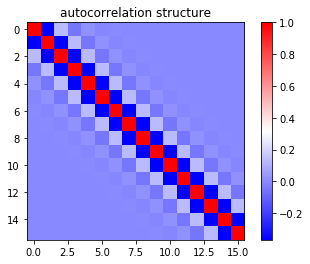

In [94]:
sigma = rho**order
im1 = plt.imshow(sigma,cmap='bwr',vmax=np.max(sigma),vmin=np.min(sigma))
cbar = plt.colorbar(im1)
plt.title('autocorrelation structure')
plt.show()

Note that you can simply perform autocorrelation using the time-series (tsa) module of the statsmodel package. Here is another example using sun spot time-series:

In [95]:
data = sm.datasets.sunspots.load()
data.data

rec.array([( 1700.,    5. ), ( 1701.,   11. ), ( 1702.,   16. ), ( 1703.,   23. ),
 ( 1704.,   36. ), ( 1705.,   58. ), ( 1706.,   29. ), ( 1707.,   20. ),
 ( 1708.,   10. ), ( 1709.,    8. ), ( 1710.,    3. ), ( 1711.,    0. ),
 ( 1712.,    0. ), ( 1713.,    2. ), ( 1714.,   11. ), ( 1715.,   27. ),
 ( 1716.,   47. ), ( 1717.,   63. ), ( 1718.,   60. ), ( 1719.,   39. ),
 ( 1720.,   28. ), ( 1721.,   26. ), ( 1722.,   22. ), ( 1723.,   11. ),
 ( 1724.,   21. ), ( 1725.,   40. ), ( 1726.,   78. ), ( 1727.,  122. ),
 ( 1728.,  103. ), ( 1729.,   73. ), ( 1730.,   47. ), ( 1731.,   35. ),
 ( 1732.,   11. ), ( 1733.,    5. ), ( 1734.,   16. ), ( 1735.,   34. ),
 ( 1736.,   70. ), ( 1737.,   81. ), ( 1738.,  111. ), ( 1739.,  101. ),
 ( 1740.,   73. ), ( 1741.,   40. ), ( 1742.,   20. ), ( 1743.,   16. ),
 ( 1744.,    5. ), ( 1745.,   11. ), ( 1746.,   22. ), ( 1747.,   40. ),
 ( 1748.,   60. ), ( 1749.,   80.9), ( 1750.,   83.4), ( 1751.,   47.7),
 ( 1752.,   47.8), ( 1753.,   30.7), ( 17

In [96]:
#-- Get the keys
print data.keys()

['data', 'raw_data', 'endog', 'names', 'endog_name']


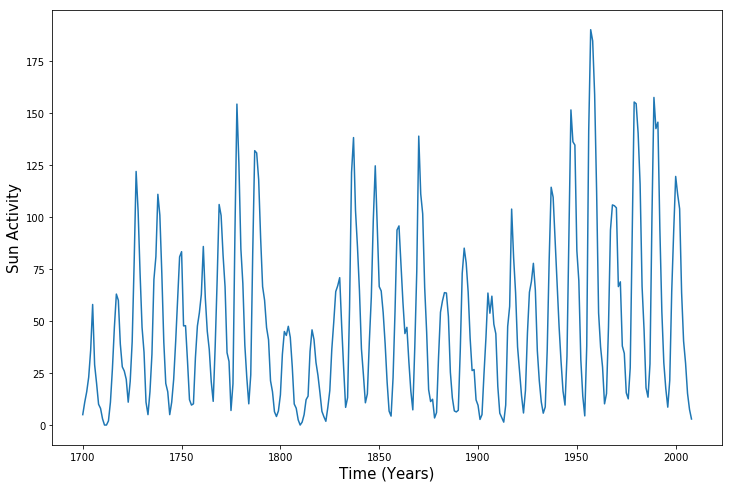

In [97]:
#-- raw_data all the data as a 1D list (i.e. each year followed by sunsplot value). Separate into separate arrays
n = len(data['raw_data'])
t = data['raw_data'][np.arange(0,n,2)] #years
y = data['raw_data'][np.arange(1,n,2)] # sunspots
#-- plot data
fig = plt.figure(figsize=(12,8))
plt.plot(t,y)
plt.xlabel('Time (Years)',fontsize=15)
plt.ylabel('Sun Activity',fontsize=15)
plt.show()

In [98]:
#-- Get autocorrelation function with lag of 50 years
autocorr_50 =  statsmodels.tsa.stattools.acf(y, nlags=50)
print autocorr_50

[ 1.          0.82020129  0.45126849  0.03957655 -0.27579196 -0.42523943
 -0.37659509 -0.15737391  0.15820254  0.47309753  0.65898002  0.65029082
  0.45666254  0.16179329 -0.12205105 -0.3161808  -0.37471125 -0.30605753
 -0.1348069   0.09158727  0.2975632   0.4207074   0.41183954  0.27020758
  0.04496208 -0.17428715 -0.33045026 -0.37287834 -0.28555061 -0.11794414
  0.08293231  0.24897507  0.32752101  0.28335919  0.1375272  -0.05526386
 -0.22973205 -0.31338879 -0.29355684 -0.17897285 -0.01769038  0.13485771
  0.22969024  0.22737088  0.1442275   0.01368029 -0.11163993 -0.18460376
 -0.20149721 -0.15643521 -0.0708259 ]


In [99]:
#-- Get autocovariance
autocov = statsmodels.tsa.stattools.acovf(y)
print autocov[:5],'...'

[ 1631.11660561  1337.84395127   736.0715309     64.55397046  -449.84884747] ...


One can also plot the autocorrelation:

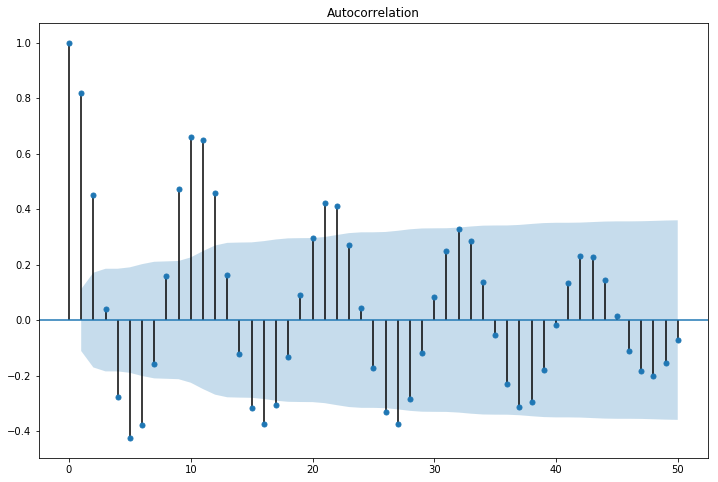

In [100]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
sm.graphics.tsa.plot_acf(y, lags=50, ax=ax1)
plt.show()